In [1]:
# For data manipulation
import numpy as np
import pandas as pd

# For OS module
import os

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For statistics
from scipy import stats
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import boxcox
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#!pip install catboost
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool


# For metrics and helpful functions
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, PredefinedSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import re
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
#!pip install -U imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
#!pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder



# For saving models
import pickle
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
file = 'Churn_Modelling.csv'
df_original = pd.read_csv(file)
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Check class balance
df_original['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

## Select an evaluation metric  

The data contains 10,000 observations, and the class distribution is approximately 80/20. 

Since we have some imbalance in our target classes, we know that if we measure model performance by accuracy alone, the model could predict 0 (no churn) 100% of the time and have an accuracy of ~80%. An accuracy of 80% might seem pretty good, but we know in this case it would be meaningless, because our model would fail to identify anybody who churned. Therefore, accuracy is not the best metric to use to evaluate our model's performance.  

To determine which evaluation metric might be best, consider how our model might be wrong. There are two possibilities for bad predictions: 
  
  - **False positives:** When the model predicts a customer **will** churn when in fact they won't
  - **False negatives:** When the model predicts a customer will **not** churn when in fact they will     

As we all know, there are a number of performance metrics aside from accuracy to choose from. Some of these include precision, recall, and F1 score. Let's examine these more closely, beginning with _precision:_

$$precision = \frac{\text{TP}}{\text{FP+TP}}$$
  </br> 

And _recall:_ 

$$recall = \frac{\text{TP}}{\text{FN+TP}}$$  
  </br>

recision represents the percentage of all our model's predicted positives that are true positives. This might not be the best metric for us to use, because it disincentivizes predicting someone will churn unless there is a high degree of certainty that they will. This could translate to a high rate of false negatives.

On the other hand, recall represents the percentage of all actual positives that the model identifies as such. This also might not be the best metric to use, because it rewards predicting someone will churn even if the likelihood of their doing so is very small. This could translate to a high rate of false positives.

So which is worse, false positives or false negatives? Well, we'd first have to define what _worse_ means. This is dependent on the details of the project that you're working on. Let us suppose that we're defining it as the error that would cost the bank more money.

We can quickly get an idea of how much money each customer who churns costs the bank by calculating the average balance of all customers who churned.

In [4]:
# Calculate average balance of customers who churned
avg_churned_bal = df_original[df_original['Exited']==1]['Balance'].mean()
avg_churned_bal

91108.53933726068

This shows that the customers who churned each took with them $91,108.54, on average. That's a lot of money! This represents the average cost of the model predicting a false negative. 

What's the cost of predicting a false positive? Well, it's the cost of whatever the incentive might be to convince someone to stay with the bank when they were going to stay regardless of whether or not they were incentived. We don't have a number for this, and even if it's probably less than $91,108.54, it still could be thousands of Dollars per customer in lost revenue, depending on the details of the incentive. 

Since correctly identifying customers who will churn is potentially very valuable, we *could* select recall as our most important metric. This might be a perfectly valid approach, depending on the specifics of the campaign. But this could also be problematic. After all, if we select a model based solely on recall, we could select a very biased model that predicts everyone to churn, but then 8,000 people would be given incentives needlessly.  

Since we don't know the exact cost of predicting a false negative, we'll make an assumption. We'll assume that a metric that balances precision and recall is best. The metric that helps us achieve this balance is _F1 score_, which is defined as the harmonic mean of precision and recall. 

$${F_{1}} = 2 \cdot \frac{precision \cdot  recall}{precision + recall}$$  
</br>

## Feature engineering

### Feature selection

We begin by dropping the columns that we wouldn't expect to offer any predictive signal to the model. These columns include `RowNumber`, `CustomerID`, and `Surname`. We'll drop these columns so they don't introduce noise to our model.  


In [5]:
# Create a new df that drops RowNumber, CustomerId, Surname, and Gender cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname'], 
                            axis=1)

In [6]:
churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
churn_df.to_csv("churn_df.csv")

### Feature Extraction

Let's create a `Loyalty` feature that represents the percentage of each customer's life that they were customers. We can do this by dividing `Tenure` by `Age`:
​
$$\text{Loyalty} = \frac{\text{Tenure}}{\text{Age}}$$
  </br> 
The intuition here is that people who have been customers for a greater proportion of their lives might be less likely to churn. 

In [9]:
# Create Loyalty variable
churn_df['Loyalty'] = churn_df['Tenure'] / churn_df['Age']

In [10]:
churn_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.190476
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.025641
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.046512


### Split the data

- Split the data 80/20 into an interim training set and a test set.
- Split the interim training set 75/25 into a training set and a validation set.

In [11]:
y = churn_df['Exited']


X = churn_df.copy()
X = X.drop('Exited', axis=1)

# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)


In [12]:
for x in [X_tr, X_test]:
    print(len(x))

8000
2000


## Preprocessing

### Feature Transformation

In [13]:
# Create Column Transformer with 3 types of transformers
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

In [15]:
X_tr = preprocessor.fit_transform(X_tr)

In [16]:
X_test = preprocessor.transform(X_test)

### Oversampling Technique

In [17]:
churn_df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [18]:
X_tr.shape,y_tr.shape

((8000, 14), (8000,))

<Axes: xlabel='Exited', ylabel='count'>

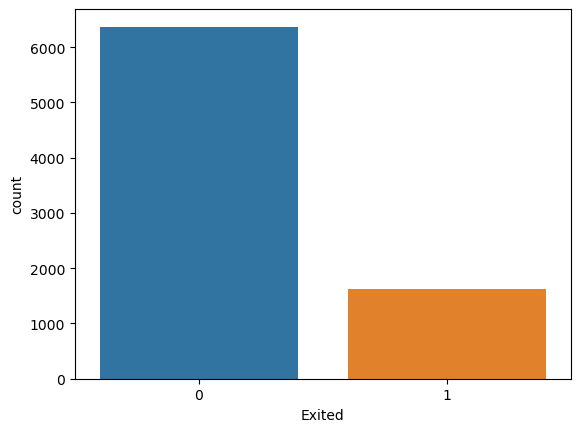

In [19]:
sns.countplot(x=y_tr,data=churn_df)

Since we have imbalance dataset, we can use SMOTE technique that oversample the minority class.

In [20]:
over = SMOTE(random_state=42)

In [21]:
#Oversampling X and y only on training data
x_smote, y_smote = over.fit_resample(X_tr, y_tr)

<Axes: xlabel='Exited', ylabel='count'>

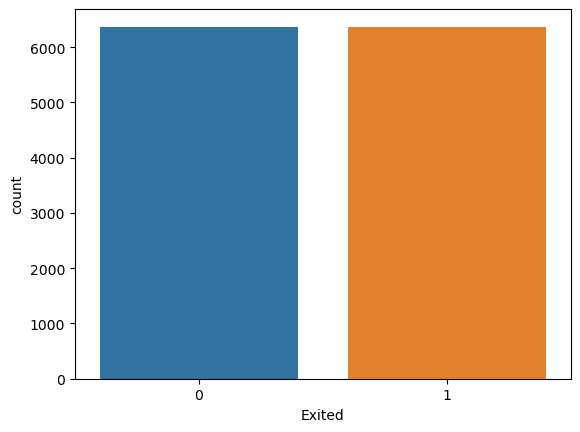

In [22]:
sns.countplot(x=y_smote,data=churn_df)

In [23]:
y_smote.shape,x_smote.shape    

((12740,), (12740, 14))

In [24]:
# Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(x_smote, y_smote, stratify=y_smote,
                                                  test_size=0.25, random_state=42)

In [25]:
for x in [X_train, X_val, X_test]:
    print(len(x))

9555
3185
2000


## Modeling

In [26]:
path = r'C:/Users/User/ML Project/'

In [27]:
def write_pickle(path, model_object, save_as:str):

    with open(path +  save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [28]:
def read_pickle(path, saved_model_name:str):

    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [37]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                        'F1': [f1],
                        'Recall': [recall],
                        'Precision': [precision],
                        'Accuracy': [accuracy]
                         }
                        )
  
    return table

### XGBoost

In [30]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [100, 200, 300, 500]
             }    

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')


In [31]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 2h 29min 26s
Wall time: 8min 8s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 500]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [32]:
xgb_cv.best_score_

0.9009903081595523

In [33]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 300}

In [34]:
# Write pickle
write_pickle(path, xgb_cv, 'xgb_cv_model')

In [35]:
# Read pickle
xgb_cv = read_pickle(path, 'xgb_cv_model')

In [38]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.90099,0.892423,0.909781,0.901936


### CatBoost

In [39]:
CB = CatBoostClassifier()
cv_params = {'iterations': [500],
            'depth': [4, 5, 6],
            'loss_function': ['Logloss', 'CrossEntropy'],
            'l2_leaf_reg': np.logspace(-20, -19, 3),
            'leaf_estimation_iterations': [10],
            'random_seed': [42],
            'early_stopping_rounds': [200],
            'logging_level': ['Silent']
         }
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
CB_cv = GridSearchCV(CB, cv_params, scoring=scoring, cv=5, refit='f1')

In [40]:
%%time
CB_cv.fit(X_train, y_train)

CPU times: total: 1min 1s
Wall time: 1min 22s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020EB7623E20>,
             param_grid={'depth': [4, 5, 6], 'early_stopping_rounds': [200],
                         'iterations': [500],
                         'l2_leaf_reg': array([1.00000000e-20, 3.16227766e-20, 1.00000000e-19]),
                         'leaf_estimation_iterations': [10],
                         'logging_level': ['Silent'],
                         'loss_function': ['Logloss', 'CrossEntropy'],
                         'random_seed': [42]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [41]:
CB_cv.best_score_

0.9016224119108589

In [42]:
CB_cv.best_params_

{'depth': 6,
 'early_stopping_rounds': 200,
 'iterations': 500,
 'l2_leaf_reg': 3.162277660168379e-20,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'random_seed': 42}

In [43]:
# Write pickle
write_pickle(path, CB_cv, 'CB_cv_model')

In [44]:
# Read pickle
CB_cv = read_pickle(path, 'CB_cv_model')

In [45]:
CB_cv_results = make_results('CatBoost CV', CB_cv)
CB_cv_results

,Model,F1,Recall,Precision,Accuracy
0,CatBoost CV,0.901622,0.882589,0.921608,0.903715


In [46]:
# Create xgb model results table
results_cv = pd.concat([CB_cv_results, xgb_cv_results]).sort_values(by=['F1'], 
                                                           ascending=False)
results_cv

,Model,F1,Recall,Precision,Accuracy
0,CatBoost CV,0.901622,0.882589,0.921608,0.903715
0,XGBoost CV,0.900990,0.892423,0.909781,0.901936


### Hyperparameters tuned with separate validation set

In [47]:
# Split into train and validate sets
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,test_size=0.25, random_state=42)

#### XGBoost

In [48]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [100, 200, 300, 500]
             }     

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

xgb_val = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [49]:
%%time
xgb_val.fit(X_val, y_val)

CPU times: total: 1h 34min 43s
Wall time: 5min 33s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 500]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [50]:
# Write pickle
write_pickle(path, xgb_val, 'xgb_val_model')

In [51]:
# Read pickle
xgb_val = read_pickle(path, 'xgb_val_model')

In [52]:
xgb_val.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 500}

In [53]:
# Create model results table
xgb_val_results = make_results('XGBoost Validated', xgb_val)
xgb_val_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost Validated,0.874958,0.856793,0.894311,0.877551


In [54]:
results_val = pd.concat([xgb_val_results, results_cv]).sort_values(by=['F1'], 
                                                           ascending=False)
results_val

,Model,F1,Recall,Precision,Accuracy
0,CatBoost CV,0.901622,0.882589,0.921608,0.903715
0,XGBoost CV,0.900990,0.892423,0.909781,0.901936
0,XGBoost Validated,0.874958,0.856793,0.894311,0.877551


#### CatBoost

In [55]:
CB = CatBoostClassifier()
cv_params = {'iterations': [500],
            'depth': [4, 5, 6],
            'loss_function': ['Logloss', 'CrossEntropy'],
            'l2_leaf_reg': np.logspace(-20, -19, 3),
            'leaf_estimation_iterations': [10],
            'random_seed': [42],
            'early_stopping_rounds': [200],
            'logging_level': ['Silent']
         }
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
CB_val = GridSearchCV(CB, cv_params, scoring=scoring, cv=5, refit='f1')

In [56]:
%%time
CB_val.fit(X_val, y_val)

CPU times: total: 49.8 s
Wall time: 52 s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020EB99FBFD0>,
             param_grid={'depth': [4, 5, 6], 'early_stopping_rounds': [200],
                         'iterations': [500],
                         'l2_leaf_reg': array([1.00000000e-20, 3.16227766e-20, 1.00000000e-19]),
                         'leaf_estimation_iterations': [10],
                         'logging_level': ['Silent'],
                         'loss_function': ['Logloss', 'CrossEntropy'],
                         'random_seed': [42]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [57]:
CB_val.best_score_

0.8823585422523734

In [58]:
CB_val.best_params_

{'depth': 5,
 'early_stopping_rounds': 200,
 'iterations': 500,
 'l2_leaf_reg': 1e-19,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'random_seed': 42}

In [59]:
# Write pickle
write_pickle(path, CB_val, 'cb_val_model')

In [60]:
# Read pickle
CB_val = read_pickle(path, 'cb_val_model')

In [61]:
# Create model results table
cb_val_results = make_results('CatBoost Validated', CB_val)
cb_val_results

,Model,F1,Recall,Precision,Accuracy
0,CatBoost Validated,0.882359,0.854898,0.911843,0.886028


In [62]:
results_val = pd.concat([cb_val_results, results_val]).sort_values(by=['F1'], 
                                                           ascending=False)
results_val

,Model,F1,Recall,Precision,Accuracy
0,CatBoost CV,0.901622,0.882589,0.921608,0.903715
0,XGBoost CV,0.900990,0.892423,0.909781,0.901936
0,CatBoost Validated,0.882359,0.854898,0.911843,0.886028
0,XGBoost Validated,0.874958,0.856793,0.894311,0.877551


## Model selection and final results

### Predicting on the test data

We're ready to select a champion model! Based on the above table, it's clear that our XGBoost model has the top F1 score on the validation data by a small margin

In [76]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'Model': [model_name],
                        'F1': [f1],
                        'Recall': [recall],
                        'Precision': [precision],
                        'Accuracy': [accuracy]
                        })

    return table

In [77]:
cb_test_preds = CB_val.best_estimator_.predict(X_test)

In [78]:
cb_test_scores = get_test_scores('CB test', cb_test_preds, y_test)
cb_test_scores

,Model,F1,Recall,Precision,Accuracy
0,CB test,0.60281,0.579853,0.62766,0.8445


In [79]:
results_test = pd.concat([cb_test_scores, results_val]).sort_values(by=['F1'], 
                                                           ascending=False)
results_test

,Model,F1,Recall,Precision,Accuracy
0,CatBoost CV,0.901622,0.882589,0.921608,0.903715
0,XGBoost CV,0.900990,0.892423,0.909781,0.901936
0,CatBoost Validated,0.882359,0.854898,0.911843,0.886028
0,XGBoost Validated,0.874958,0.856793,0.894311,0.877551
0,CB test,0.602810,0.579853,0.627660,0.844500


### Confusion matrix

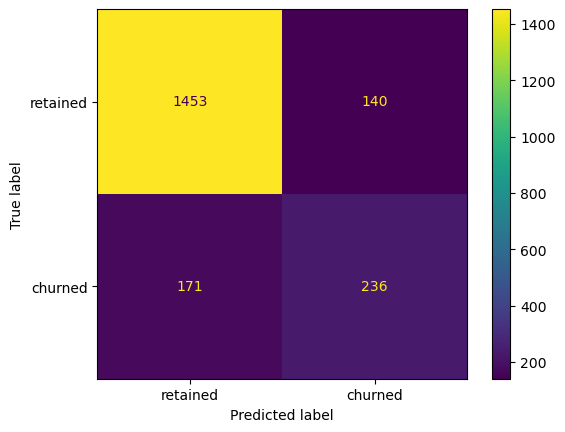

In [80]:
cm = confusion_matrix(y_test, cb_test_preds, labels=CB_val.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

From the 2000 people in our test data, there are 407 customers who left the bank. Of those, our model captures 236. The confusion matrix indicates that, when the model makes an error, it’s usually a Type II error (171) — it gives a false negative by failing to predict that a customer will leave. On the other hand, it makes fewer Type I errors (140), which are false positives.

Ultimately, whether these results are acceptable depends on the costs of the measures taken to prevent a customer from leaving versus the value of retaining them. In this case, bank leaders may decide that they’d rather have more true positives, even if it means also capturing significantly more false positives. If so, perhaps optimizing the models based on their F1 scores is insufficient. Maybe we’d prioritize a different evaluation metric.

One way to modify the decision-making without retraining the model is to adjust the threshold at which the model predicts a positive response. In other words, the model determines a probability that a given customer will churn. By default, if that probability is ≥ 0.50, then the model will label that customer as churned. Probabilities of < 0.50 would designate a non-responder. But it's possible to adjust this decision threshold. For instance, if we set the threshold to 0.3, then the model would label customers with predicted probabilities ≥ 0.3 as churned, and those with probabilities < 0.3 as not churned. This would increase the recall of the model, but decrease the accuracy.

In any case, what is certain is that our model helps the bank. Consider the results if decision-makers had done nothing. In that case, they’d expect to lose 407 customers. Alternatively, they could give everybody an incentive to stay. That would cost the bank for each of the 2 000 customers in our test set. Finally, the bank could give incentives at random—say, by flipping a coin. Doing this would incentivize about the same number of true responders as our model selects. But the bank would lose a lot of money offering the incentives to people who aren’t likely to leave, and our model is very good at identifying these customers.

### Identify an optimal decision threshold

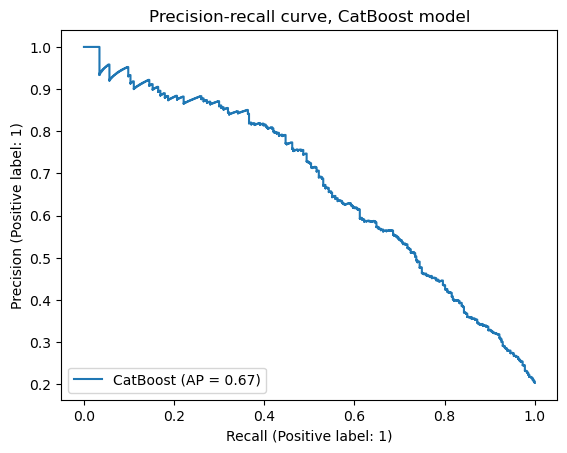

In [81]:
display = PrecisionRecallDisplay.from_estimator(
    CB_val.best_estimator_, X_test, y_test, name='CatBoost'
    )
plt.title('Precision-recall curve, CatBoost model');

In [82]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall

In [83]:
probabilities = CB_val.best_estimator_.predict_proba(X_test)

threshold_finder(y_test, probabilities, 0.7)

(0.34900000000000003, 0.7002457002457002)

In [84]:
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.349 else 0 for x in probs])

get_test_scores('CB with threshold', new_preds, y_test)

,Model,F1,Recall,Precision,Accuracy
0,CB with threshold,0.610932,0.700246,0.541825,0.8185


In [ ]:
results_test